# EDA of Team _**Sixth Sense**_'s Final Project Dataset

In [1]:
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from pycocotools.coco import COCO
from tqdm import tqdm

/opt/conda/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CAT_NAME = ["ambulance", "fire truck", "police"]
COLOR = ["g", "r", "b"]
IMAGES_DIR = "/opt/ml/input/images/"
LABEL_PATH = "/opt/ml/final-project-level3-cv-17/data/주행 차량 관점의 특수 차량 형상 데이터/total_ver4.json"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# bins = 30
window_height = 6
window_aspect = 1.8

sns.set_theme(style="darkgrid")

In [3]:
# insert image metadata of date captured
label = json.load(open(LABEL_PATH, "r"))
annos = label["images"]
for anno in annos:
    file_name = anno["file_name"]
    if file_name.startswith("P_"): continue

    date_ = file_name[:10]
    time_ = file_name[11:19].replace("-", ":")

    date_captured = date_ + " " + time_
    anno["date_captured"] = date_captured

json.dump(label, open("./labels.json", "w", encoding="utf8"), ensure_ascii=False, indent=4)

In [4]:
coco = COCO("./labels.json")

n_total_images = len(os.listdir(IMAGES_DIR))
n_valid_images = len(coco.getImgIds())

print()
print(f"Total number of images: {n_total_images}")
print(f"Number of valid images: {n_valid_images} ({n_valid_images/n_total_images*100:>2.1f}%)")

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!

Total number of images: 16852
Number of valid images: 14915 (88.5%)


## Indices
1. **Image**
    1. 이미지 크기 분포
    2. 이미지 밝기 분포
    3. 촬영 시간과 밝기 분포
    4. 이미지별 GT Box 개수 분포
2. **Ground Truth Box**
    1. 클래스 개수 분포
    2. 클래스별 박스 크기 분포
    3. 클래스별 위치 분포

## 1. Image

In [5]:
avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
def get_brigthness(file_name):
    image_path = os.path.join(IMAGES_DIR, file_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = torch.tensor(image, dtype=torch.float32)
    image = image.to(DEVICE)
    image = image.permute(2, 1, 0)
    pixs = avgpool(image)
    return np.mean([pix.item() for pix in pixs]).item()

In [6]:
img_ids = []
height, width = [], []
date_captured, time_captured = [], []
img_brightness = []
n_objects = []
cnt = dict()

for img_id in coco.getImgIds():
    cnt[img_id] = 0
for ann_id in coco.getAnnIds():
    ann = coco.loadAnns(ann_id)[0]
    img_id = int(ann["image_id"])
    cnt[img_id] += 1

for img_id in tqdm(coco.getImgIds()):
    img = coco.loadImgs(img_id)[0]
    img_ids.append(img_id)

    n_objects.append(cnt[img_id])
    
    file_name = img["file_name"]
    height.append(img["height"])
    width.append(img["width"])

    try:
        date_time = img["date_captured"]
    except:
        print(img)
    date_captured.append(date_time[:10])
    h = int(date_time[11:13])
    m = int(date_time[14:16])
    time_captured.append(h * 60 + m)

    img_brightness.append(get_brigthness(file_name))


img_data = {
    "image id": img_ids,
    "height": height,
    "width": width,
    "date": date_captured,
    "time": time_captured,
    "brightness": img_brightness,
    "num of objects": n_objects
}
img_df = pd.DataFrame(img_data)

100%|██████████| 14915/14915 [14:28<00:00, 17.18it/s]


In [7]:
import copy
archive = copy.deepcopy(img_data)

### 1.1. 이미지 크기 분포

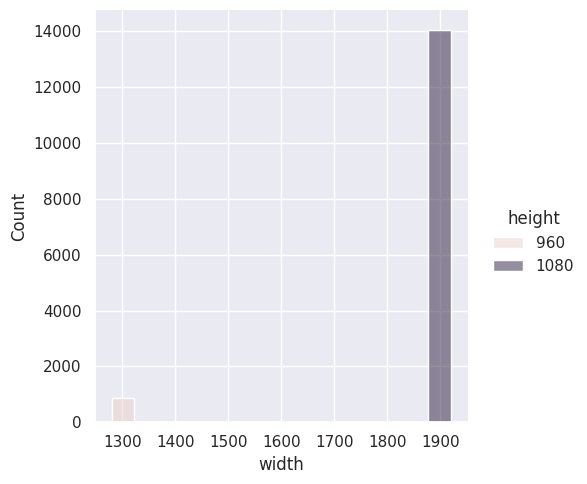

In [8]:
sns.displot(
    img_df,
    x="width",
    hue="height"
)
plt.show()

- 크기는 두 종류, 1920x1080이 훨씬 많습니다.

### 1.2. 이미지 밝기 분포

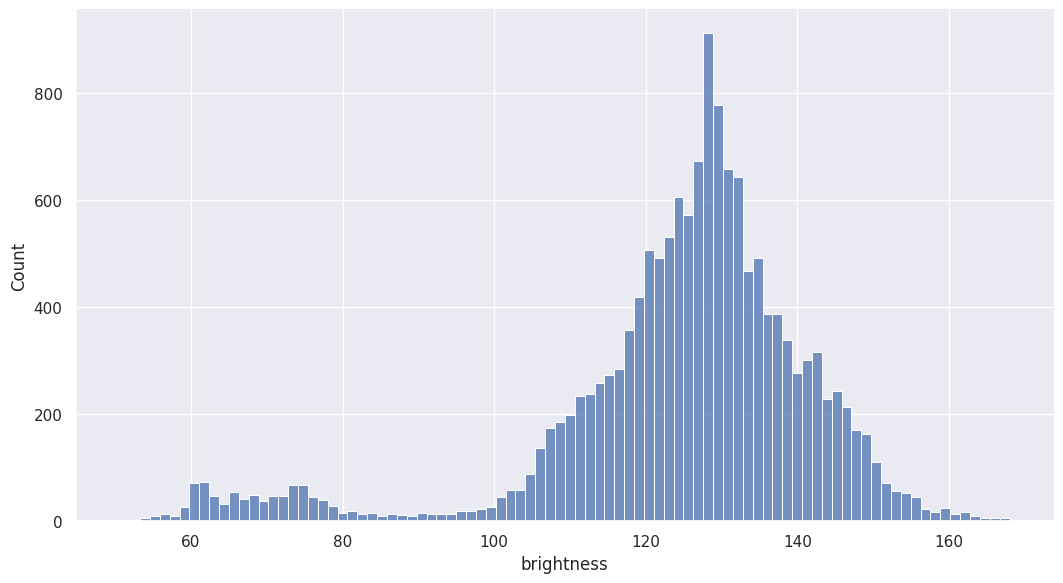

In [9]:
sns.displot(
    img_df,
    x="brightness",
    height=window_height,
    aspect=window_aspect
)
plt.show()

- 저녁 사진은 별로 없습니다. 밝은 사진이 압도적으로 많습니다. (저녁 사진 정확도 문제)

### 1.3. 촬영 시간과 밝기 분포

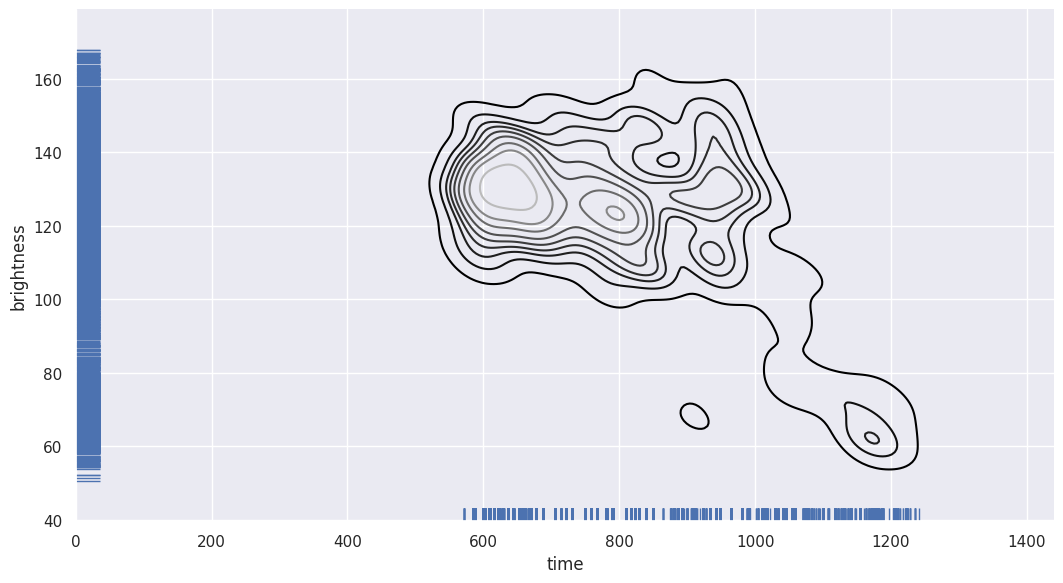

In [10]:
sns.displot(
    img_df,
    x="time",
    y="brightness",
    cmap="gray",
    kind="kde",
    rug=True,
    height=window_height,
    aspect=window_aspect,
)
plt.xlim(0, 1440)
plt.show()

- 시간은 자정부터의 시간을 분으로 나타낸 것입니다.
- 정오를 전후로 등고선이 많습니다. 낮에 찍은 사진이 밝습니다.
- 정오를 전후로 등고선이 밀집돼 있습니다. 낮에 찍은 사진이 많습니다.

### 1.4. 이미지별 GT Box 개수 분포

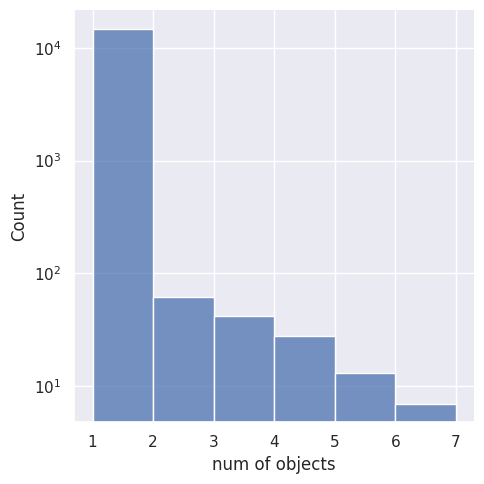

In [11]:
sns.displot(
    img_df,
    x="num of objects",
    binwidth=1,
    log_scale=(False, True)
)
plt.show()

In [12]:
anns = dict()
for img_id in coco.getImgIds():
    anns[img_id] = []
for ann_id in coco.getAnnIds():
    ann = coco.loadAnns(ann_id)[0]
    img_id = int(ann["image_id"])
    anns[img_id].append(ann_id)

def vis_image(image_ids):
    plt.style.use("default")
    for image_id in image_ids:
        image_info = coco.loadImgs(image_id)[0]
        file_name = image_info["file_name"]
        image_path = os.path.join(IMAGES_DIR, file_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = anns[image_id]
        for ann_id in ann_ids:
            ann_info = coco.loadAnns(ann_id)[0]
            bbox = ann_info["bbox"]
            print(bbox)
            xmin, ymin = int(bbox[0]), int(bbox[1])
            xmax, ymax = int(xmin + bbox[2]), int(ymin + bbox[3])
            image = cv2.rectangle(image, [xmin, ymin], [xmax, ymax], (255, 0, 0), 2)
        
        plt.imshow(image)
        plt.show()
    sns.set_theme(style="darkgrid")

## 2. Ground Truth Box

In [13]:
ann_ids = []
vehicle_type = []
image_width, image_height = [], []
area, box_size = [], []
xcenter, ycenter = [], []

for ann_id in tqdm(coco.getAnnIds()):
    ann = coco.loadAnns(ann_id)[0]
    ann_ids.append(ann_id)
    
    # category id
    v_type_no = ann["category_id"] - 1
    vehicle_type.append(CAT_NAME[v_type_no])

    # image width and height
    image = coco.loadImgs(ann["image_id"])[0]
    img_w = image["width"]
    img_h = image["height"]
    image_width.append(img_w)
    image_height.append(img_h)

    # unit of the gt box area = number of pixels
    area.append(ann["area"])
    if ann["area"] < 32**2:
        box_size.append("small")
    elif ann["area"] < 96**2:
        box_size.append("medium")
    else:
        box_size.append("large")

    # center of the gt box
    # unit of coordinates of gt box = relative position
    # to the upper left corner of the image
    x, y, w, h = ann["bbox"]
    x, y, w, h = x/img_w, y/img_h, w/img_w, h/img_h
    xcenter.append(x + (w / 2))
    ycenter.append(y + (h / 2))


box_data = {
    "id": ann_ids,
    "vehicle type": vehicle_type,
    "x center": xcenter,
    "y center": ycenter,
    "area": area,
    "box size": box_size,
    "image width": image_width,
    "image height": image_height
}
box_df = pd.DataFrame(box_data)

100%|██████████| 15233/15233 [00:00<00:00, 268918.60it/s]


### 2.1. 클래스 개수와 박스 크기 분포

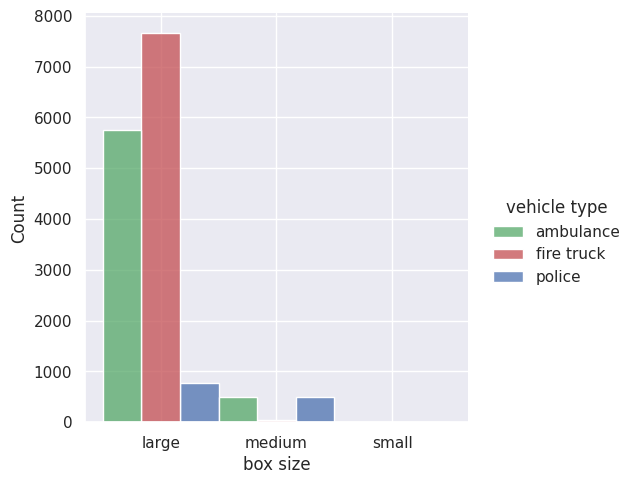

In [14]:
sns.displot(box_df, x="box size", hue="vehicle type", multiple="dodge", palette=COLOR, hue_order=CAT_NAME)
plt.show()

- large, medium, small은 COCO 기준입니다. small < 32^2 < medium < 96^2 < large
- 소방차가 가장 많고 구급차는 그보다 약간 적습니다. 경찰차가 많이 부족합니다. (class imbalance)
- green ambulance, red fire truck, blue police 실제 색으로 기억하시면 편합니다

### 2.2. 클래스별 박스 크기 분포

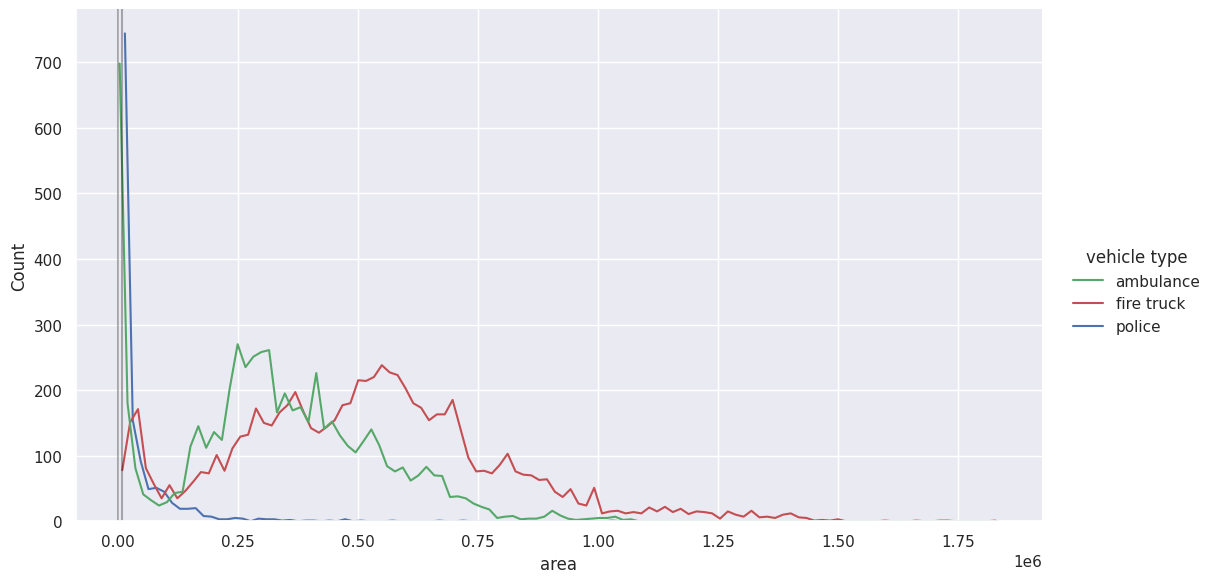

In [15]:
sns.displot(
    box_df,
    x="area",
    hue="vehicle type",
    binwidth=16384,
    multiple="dodge",
    element="poly",
    fill=False,
    palette=COLOR,
    hue_order=CAT_NAME,
    height=window_height,
    aspect=window_aspect,
)

# small
plt.axvline(32**2, alpha=0.3, color="black")
# medium
plt.axvline(96**2, alpha=0.3, color="black")
# large

plt.show()

- 그래프가 아주 정확한 건 아니기 때문에 대략적으로만 파악해야 합니다.
- 경찰차의 선이 구급차의 선보다 약간 더 오른쪽에 있습니다. 시각적 편의를 위해 그렇게 그린 것입니다.
- 왼쪽 회색 세로선 두 개가 COCO 데이터셋에서 small, medium, large를 구분하는 선입니다. 거의 대부분이 large입니다.
- small은 경찰차만 조금 있고, medium은 소방차가 거의 없습니다.

### 2.3. 클래스와 크기별 위치 분포

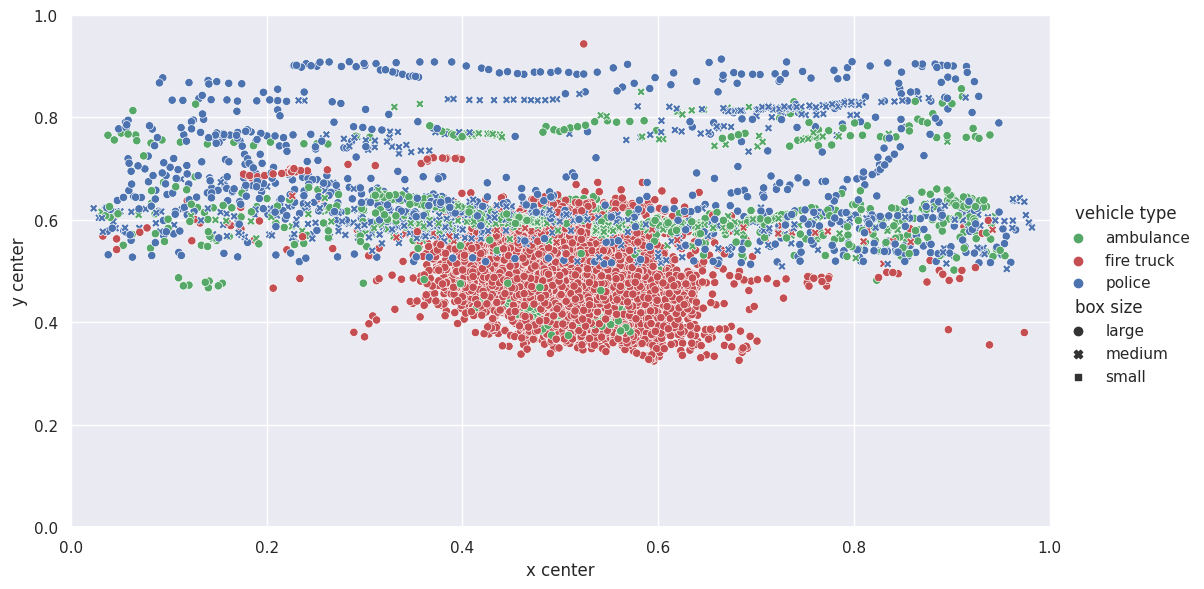

In [16]:
sns.relplot(
    box_df,
    x="x center",
    y="y center",
    hue="vehicle type",
    style="box size",
    hue_order=CAT_NAME,
    palette=COLOR,
    height=window_height,
    aspect=window_aspect,
)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

- 모든 이미지의 크기가 같은 것이 아니기 때문에 원점(좌상단 꼭지점)으로부터의 상대적 거리로 표현하였습니다. (YOLO의 regression loss가 이렇게 계산)
- 줄지어 있는 건, 영상을 연달아 캡쳐했기 때문으로 보입니다.
- 블랙박스 영상이라 지표면 위에 많이 분포합니다. 양쪽 가에서 사선으로 올라가는 점들은 좌우로 기울어진 측면 블랙박스 영상 때문으로 보입니다.
- 소방차는 사진 중앙에 몰려 있습니다. 소방차를 의도적으로 찍은 사진이 많습니다. (주행 관점 데이터셋 특징)
- 경찰차는 medium 사이즈가 높이 많이 분포돼 있습니다. (ADAS 데이터셋 특징)
- MMYOLO에서 Mosaic augmentation을 기본으로 적용합니다. 위치 imbalance가 있으므로 제외하지 않고 학습시키는 것이 좋아 보입니다.

### 2.3.a 크기별 위치 분포

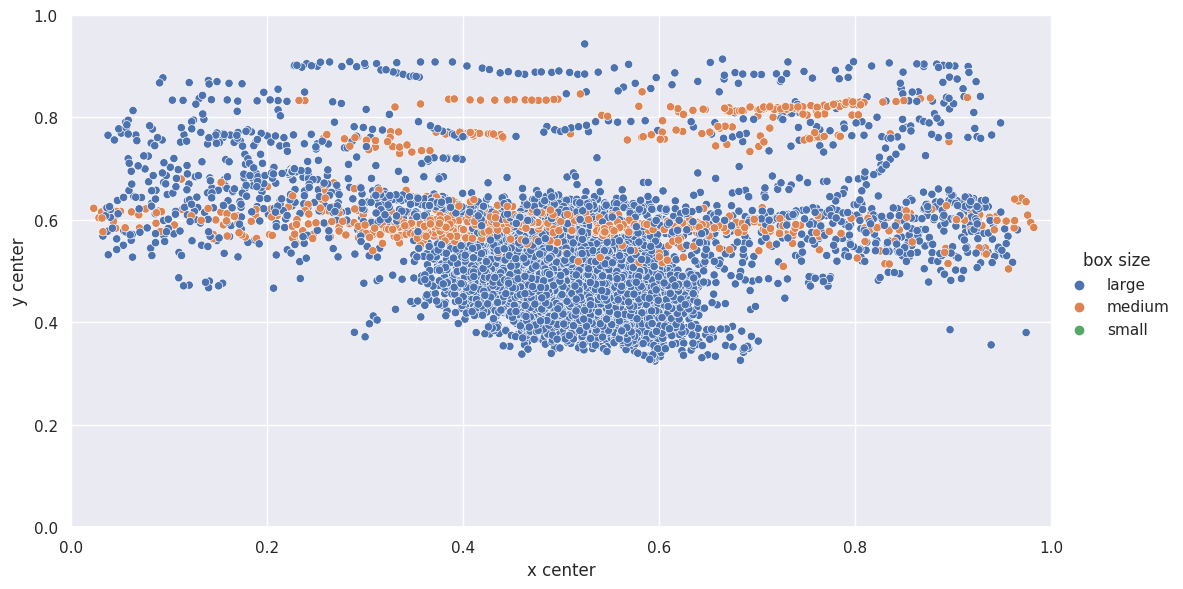

In [17]:
sns.relplot(
    box_df,
    x="x center",
    y="y center",
    hue="box size",
    height=window_height,
    aspect=window_aspect,
)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()